In [2]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from typing import List, Union
from collections import OrderedDict
import itertools
from qiskit.quantum_info import Statevector
import multiprocessing as mp
from math import pi
from scipy.special import logsumexp

num_qubits = 2

In [10]:
def final_circuit(circuit, data, params):
    d = len(params)
    layers = d//num_qubits
    angle_y = ((np.pi-data[0])*(np.pi-data[1]))
    angle_z = ((np.pi-data[2])*(np.pi-data[3]))
    for i in range(num_qubits):
        circuit.h(i)
    for j in range(layers-1):
        for i in range(num_qubits):
            circuit.ry(data[i], i)
            circuit.rz(data[i+2],i)
        circuit.cx(0,1)
        circuit.ry(angle_y, 0)
        circuit.rz(angle_z, 1)
        circuit.cx(0,1)
        for i in range(num_qubits):
            circuit.ry(params[i+num_qubits*j],i)
        circuit.cx(0,1)
        
    for i in range(num_qubits):
        circuit.h(i)
        circuit.ry(data[i], i)
        circuit.rz(data[i+2],i)
    circuit.cx(0,1)
    circuit.ry(angle_y, 0)
    circuit.rz(angle_z, 1)
    circuit.cx(0,1)
    for i in range(num_qubits):
        circuit.ry(params[i+num_qubits*(layers-1)],i)

In [12]:
def _parity():
    y1 = []
    y2 = []
    basis_states = [list(i) for i in itertools.product([0, 1], repeat=num_qubits)]
    for idx, k in enumerate(basis_states):
        parity = sum(int(k[i]) for i in range(len(k)))
        if parity % 2 == 0:
            y1.append(idx)
        else:
            y2.append(idx)
    return {'y1': y1, 'y2': y2}

In [13]:
def get_probabilities(params, x):
    
    def get_probs(inds, thetas, datas, results):
        for i, theta, data in zip(inds, thetas, datas):
            circuit = QuantumCircuit(2)
            circ_ = final_circuit(circuit, data, theta)
            result = sv.evolve(circuit)
            start = i * 2**num_qubits
            end = (i+1) * 2**num_qubits
            results[start:end] = result.probabilities()
    params = np.array(params)
    x = np.array(x)      
    
     # specify number of parallel processes
    num_processes = 2

        # construct index set per process
    indices = []
    start = 0
    size = len(x) // num_processes
    for i in range(num_processes-1):
        end = start + size
        indices += [list(range(start, end))]
        start = end
    indices += [list(range(end, len(x)))]

        # initialize shared array to store results (only supports 1D-array, needs reshaping later)
    results = mp.Array('d', (len(x) * 2**num_qubits))

        # construct processes to be run in parallel
    processes = [mp.Process(target=get_probs, args=(inds, params[inds], x[inds], results))
                     for inds in indices]

    for p in processes:
        p.start()
    for p in processes:
        p.join()
    probabilities = []
    num_probs = 2**num_qubits
    for i in range(len(x)):
        start = i * num_probs
        end = (i+1) * num_probs
        probabilities += [results[start:end]]

    return probabilities

In [14]:
def get_gradient(params, x):
    grads = []
    qc_plus = []
    qc_minus = []
    zeros = np.zeros(np.shape(params))
    for i in range(d):
        #print(i)
        zeros[:, i] = np.pi / 2.
        qc_plus += [get_probabilities(params+zeros, x)]
        qc_minus += [get_probabilities(params-zeros, x)]
        zeros[:, i] = 0
        grads.append((np.array(qc_plus[i]) - np.array(qc_minus[i])) * 0.5)
    grads = np.array(grads)
    print(grads)
    # reshape the dp_thetas
    full = np.zeros((len(x), d, 2**num_qubits))
    for j in range(len(x)):
        row = np.zeros((d, 2**num_qubits))
        for i in range(d):
            tensor = grads[i]
            row[i] += tensor[j]
        full[j] += row
    return full

In [15]:
def forward(params, x):
    def get_probs(inds, thetas, datas, results):
        for i, theta, data in zip(inds, thetas, datas):
            circuit = QuantumCircuit(2)
            circ_ = final_circuit(circuit, data, theta)
            result = sv.evolve(circuit)
            start = i * 2**num_qubits
            end = (i+1) * 2**num_qubits
            results[start:end] = result.probabilities()
        # map input to arrays
    params = np.array(params)
    x = np.array(x)
        # specify number of parallel processes
    num_processes = 2
        # construct index set per process
    indices = []
    start = 0
    size = len(x) // num_processes
    for i in range(num_processes-1):
        end = start + size
        indices += [list(range(start, end))]
        start = end
    indices += [list(range(end, len(x)))]

        # initialize shared array to store results (only supports 1D-array, needs reshaping later)
    results = mp.Array('d', (len(x) * 2**num_qubits))

        # construct processes to be run in parallel
    processes = [mp.Process(target=get_probs, args=(inds, params[inds], x[inds], results))
                     for inds in indices]

    for p in processes:
        p.start()
    for p in processes:
        p.join()

    aggregated_results = np.zeros((len(x), outputsize))
    num_probs = 2**num_qubits
    for i in range(len(x)):
        start = i * num_probs
        end = (i+1) * num_probs
        probabilities = results[start:end]
        temp_ = []
        for y in post_processing.keys():
            index = post_processing[y]  # index for each label
            temp_.append([sum(probabilities[u] for u in index)])
        temp_ = np.reshape(temp_, (1, outputsize))
        aggregated_results[i] = temp_
    return aggregated_results

In [16]:
def get_fisher(gradients, model_output):
    gradvectors = []
    for k in range(len(gradients)):
        jacobian = []
        m_output = model_output[k]  # p_theta size: (1, outputsize)
        jacobians_ = gradients[k, :, :]  # dp_theta size: (d, 2**num_qubits)
        for idx, y in enumerate(post_processing.keys()):
            index = post_processing[y]  # index for each label
            denominator = m_output[idx]  # get correct model output sum(p_theta) for indices
            for j in range(d):
                row = jacobians_[j, :]
                    # for each row of a particular dp_theta, do sum(dp_theta)/sum(p_theta) for indices
                    # multiply by sqrt(sum(p_theta)) so that the outer product cross term is correct
                jacobian.append(np.sqrt(denominator)*(sum(row[u] for u in index) / denominator))
            # append gradient vectors for every output for all data points
        gradvectors.append(np.reshape(jacobian, (outputsize, d)))
        print(np.reshape(jacobian, (outputsize, d)))
        # full gradient vector
    gradients = np.reshape(gradvectors, (len(gradients), outputsize, d))

    fishers = np.zeros((len(gradients), d, d))
    for i in range(len(gradients)):
        grads = gradients[i]  # size = (outputsize, d)
        temp_sum = np.zeros((outputsize, d, d))
        for j in range(outputsize):
            temp_sum[j] += np.array(np.outer(grads[j], np.transpose(grads[j])))
        fishers[i] += np.sum(temp_sum, axis=0)  # sum the two matrices to get fisher estimate
    return fishers

In [17]:
d = 2
num_qubits = 2
inputsize = 4
outputsize = 2
post_processing = OrderedDict(_parity())
sv = Statevector.from_label('0' * num_qubits)

num_inputs = 100
num_thetas = 100
thetamin = -1
thetamax = 1

rep_range = np.tile(np.array([num_inputs]), num_thetas)
params_ = np.random.uniform(thetamin, thetamax, size=(num_thetas, d))
params = np.repeat(params_, repeats=rep_range, axis=0)
x_ = np.random.normal(0, 1, size=(num_inputs, inputsize))
x = np.tile(x_, (num_thetas, 1))

In [18]:
def get_fhat():
    grads = get_gradient(params, x)
    output = forward(params, x)
    fishers = get_fisher(grads, output)
    fisher_trace = np.trace(np.average(fishers, axis=0))
    fisher = np.average(np.reshape(fishers, (num_thetas, num_inputs, d, d)), axis=1)
    f_hat = d * fisher / fisher_trace
    return f_hat, fisher_trace

In [19]:
def eff_dim(f_hat, n):
        effective_dim = []
        for ns in n:
            Fhat = f_hat * ns / (2 * pi * np.log(ns))
            one_plus_F = np.eye(d) + Fhat
            det = np.linalg.slogdet(one_plus_F)[1]  # log det because of overflow
            r = det / 2  # divide by 2 because of sqrt
            effective_dim.append(2 * (logsumexp(r) - np.log(num_thetas)) / np.log(ns / (2 * pi * np.log(ns))))
        return np.array(effective_dim)/d

In [20]:
n = [1000, 2000, 8000, 10000, 40000, 60000, 100000, 150000, 200000, 500000, 1000000]

###################################################################################

f, trace = get_fhat()

[[[ 0.17261291 -0.17261291 -0.10394003  0.10394003]
  [-0.13544119  0.13544119 -0.0478958   0.0478958 ]
  [-0.062884    0.062884   -0.02638698  0.02638698]
  ...
  [-0.23818035  0.23818035  0.04446032 -0.04446032]
  [ 0.00694753 -0.00694753  0.3105001  -0.3105001 ]
  [-0.04558441  0.04558441 -0.04661932  0.04661932]]

 [[ 0.06747944  0.21227108 -0.06747944 -0.21227108]
  [-0.05070195 -0.12112903  0.05070195  0.12112903]
  [ 0.14709674 -0.12106641 -0.14709674  0.12106641]
  ...
  [-0.07464812  0.07529889  0.07464812 -0.07529889]
  [-0.05309907 -0.04021001  0.05309907  0.04021001]
  [ 0.01429642  0.40115449 -0.01429642 -0.40115449]]]
[[ 0.53085713 -0.27793477]
 [-0.32399036  0.16962791]]
[[-0.40467436  0.32554581]
 [ 0.08966883 -0.07213532]]
[[-0.04953686  0.36397374]
 [ 0.05397781 -0.39660377]]
[[-0.08905617 -0.18975765]
 [ 0.20940701  0.44619684]]
[[-0.28836105  0.09244521]
 [ 0.43159664 -0.13836488]]
[[-0.48111557 -0.2287898 ]
 [ 0.73797281  0.35093575]]
[[-0.08354443 -0.11433836]
 [ 

 [-0.01090841 -0.10469726]]
[[ 0.3621918   0.39416116]
 [-0.23751682 -0.25848157]]
[[-0.24256638 -0.53914777]
 [ 0.20850203  0.46343357]]
[[-0.08753786  0.13737446]
 [ 0.1677821  -0.26330295]]
[[-0.3664018  -0.36067604]
 [ 0.9191433   0.90477984]]
[[ 0.49539842 -0.23315224]
 [-0.43791284  0.20609747]]
[[ 0.19354134 -0.35872788]
 [-0.25997772  0.48186737]]
[[ 0.2965698   0.1078936 ]
 [-0.24465433 -0.08900649]]
[[-0.04559953  0.14194785]
 [ 0.11733399 -0.36525173]]
[[-0.27392618 -0.23602143]
 [ 0.53849358  0.4639791 ]]
[[ 0.05123251 -0.00610762]
 [-0.24718888  0.02946832]]
[[ 0.35841423 -0.34529192]
 [-0.62537523  0.6024789 ]]
[[-0.30709087 -0.09328244]
 [ 0.30146519  0.09157358]]
[[-0.65746072 -0.60596903]
 [ 0.13278232  0.12238294]]
[[-0.08874618 -0.57693464]
 [ 0.07988285  0.51931458]]
[[-0.18826601 -0.14740544]
 [ 0.52597306  0.41181779]]
[[-0.48169413 -0.1046293 ]
 [ 0.31658532  0.06876584]]
[[ 0.20371564 -0.24669398]
 [-0.462349    0.55989178]]
[[ 0.10868025 -0.07829645]
 [-0.67773

 [ 0.27929993  0.12231917]]
[[-0.45626864 -0.62456474]
 [ 0.45928201  0.6286896 ]]
[[ 0.12965627  0.06016261]
 [-0.39386443 -0.18275948]]
[[ 0.29200901 -0.16371594]
 [-0.71993158  0.40363232]]
[[ 0.24038332 -0.12836503]
 [-0.48826624  0.26073485]]
[[ 0.06110133  0.10858058]
 [-0.08852487 -0.15731378]]
[[-0.3162317  -0.30815783]
 [ 0.31716441  0.30906673]]
[[-0.11879348 -0.24913977]
 [ 0.15358166  0.32209932]]
[[-0.56386876 -0.40613049]
 [ 0.55175934  0.3974086 ]]
[[-0.29187349 -0.39535389]
 [ 0.55268923  0.74863886]]
[[-0.06792532 -0.15310436]
 [ 0.1012742   0.22827306]]
[[ 0.2981992  -0.67669506]
 [-0.22116179  0.50187623]]
[[-0.14446009  0.05083245]
 [ 0.09871616 -0.03473613]]
[[-0.60542743  0.73938388]
 [ 0.34326394 -0.41921428]]
[[-0.11001025 -0.22482675]
 [ 0.2294988   0.46902417]]
[[ 0.16994801 -0.20334309]
 [-0.62132922  0.7434215 ]]
[[-0.20422956 -0.23960113]
 [ 0.39867727  0.46772625]]
[[-0.37340061 -0.31179007]
 [ 0.19734459  0.16478303]]
[[ 0.29834464 -0.32272031]
 [-0.57417

 [ 0.40731589 -0.34200026]]
[[ 0.07703681  0.07238907]
 [-0.95452686 -0.89693895]]
[[ 0.03871587  0.11639506]
 [-0.03113354 -0.09359961]]
[[-0.42783458  0.43877316]
 [ 0.45503228 -0.46666623]]
[[ 0.12160168 -0.25690829]
 [-0.13623971  0.2878341 ]]
[[ 0.00481031 -0.05925964]
 [-0.01339961  0.16507359]]
[[-0.48237779 -0.27571373]
 [ 0.22542353  0.12884582]]
[[ 0.03886103 -0.26986285]
 [-0.0680214   0.47236131]]
[[ 0.173528   -0.14643813]
 [-0.31581586  0.2665131 ]]
[[-0.18620976 -0.03879069]
 [ 0.8139042   0.16955022]]
[[ 0.56238636 -0.33332779]
 [-0.56120682  0.33262867]]
[[-0.61610621 -0.53816418]
 [ 0.6246771   0.54565079]]
[[-0.0283469  -0.20961064]
 [ 0.0334801   0.24756793]]
[[-0.10368393 -0.07854791]
 [ 0.14723289  0.11153933]]
[[-0.04187756 -0.06317221]
 [ 0.08110128  0.1223411 ]]
[[ 0.12257768  0.08633769]
 [-0.07843859 -0.05524828]]
[[ 0.37041071 -0.47219072]
 [-0.44897154  0.57233819]]
[[ 0.05855537 -0.42950524]
 [-0.08683077  0.63690602]]
[[ 0.45287153  0.08303111]
 [-0.12481

[[-0.58917063  0.57713047]
 [ 0.56190858 -0.55042554]]
[[ 0.30337778  0.19383615]
 [-0.64804701 -0.4140545 ]]
[[-0.54380403  0.55376505]
 [ 0.7186121  -0.73177513]]
[[-0.15865177  0.17068929]
 [ 0.39254736 -0.42233143]]
[[-0.22939078 -0.05854297]
 [ 0.25163723  0.06422051]]
[[-0.71620528 -0.72661506]
 [ 0.60737018  0.61619808]]
[[-0.15440817 -0.20261445]
 [ 0.34628124  0.45439037]]
[[-0.12723734  0.34661519]
 [ 0.22520079 -0.61348356]]
[[-0.1251408  -0.32244721]
 [ 0.1198216   0.30874136]]
[[ 0.19419901  0.26712884]
 [-0.44990903 -0.61886862]]
[[-0.48527018  0.51647435]
 [ 0.75976172 -0.80861644]]
[[ 0.39887846  0.15679216]
 [-0.36927608 -0.14515598]]
[[-0.03060182 -0.13197413]
 [ 0.03054039  0.13170922]]
[[-0.44002996  0.19715722]
 [ 0.51128879 -0.22908503]]
[[-0.22844824 -0.4625953 ]
 [ 0.25499599  0.51635305]]
[[-0.30442959 -0.09772519]
 [ 0.85924808  0.27582792]]
[[ 0.50260037  0.56195971]
 [-0.55699094 -0.62277405]]
[[-0.5284079   0.52997068]
 [ 0.62778979 -0.6296465 ]]
[[-0.53160

[[-0.17908729 -0.0816331 ]
 [ 0.20056682  0.09142408]]
[[-0.52114009  0.4962663 ]
 [ 0.43364713 -0.41294934]]
[[-0.36482213  0.40684302]
 [ 0.4947063  -0.55168748]]
[[ 0.0326129  -0.3121988 ]
 [-0.05381662  0.5151792 ]]
[[-0.33195669  0.0273175 ]
 [ 0.29408708 -0.02420113]]
[[ 0.09552781  0.26839698]
 [-0.19295734 -0.54213707]]
[[ 0.50671844 -0.19984643]
 [-0.31068153  0.12253076]]
[[-0.66047931  0.24998146]
 [ 0.40090328 -0.15173584]]
[[ 0.16577701  0.21393434]
 [-0.19097794 -0.24645601]]
[[ 0.10286437  0.15990143]
 [-0.46190139 -0.71802017]]
[[ 0.20378645 -0.28484354]
 [-0.35491799  0.49608841]]
[[ 0.03575782  0.03648868]
 [-0.17345043 -0.17699561]]
[[ 0.08180853  0.04511098]
 [-0.09974938 -0.05500395]]
[[ 0.36992346 -0.3780193 ]
 [-0.53820853  0.54998731]]
[[-0.29058719  0.13432347]
 [ 0.23363351 -0.10799672]]
[[-0.07885901 -0.03892655]
 [ 0.09444321  0.04661926]]
[[-0.16522993 -0.1945052 ]
 [ 0.30864248  0.36332744]]
[[-0.32007787  0.01468292]
 [ 0.35441013 -0.01625784]]
[[-0.17182

[[ 0.12122712  0.23907457]
 [-0.30145181 -0.59449946]]
[[ 0.44568045 -0.428483  ]
 [-0.77065137  0.74091429]]
[[ 0.6068233  -0.5879581 ]
 [-0.51346081  0.49749811]]
[[-0.16436153 -0.13208652]
 [ 0.23597676  0.18963896]]
[[-0.76743894 -0.74353273]
 [ 0.5671701   0.5495024 ]]
[[-0.08944924 -0.42537605]
 [ 0.09533577  0.45336943]]
[[ 0.22510545 -0.09632535]
 [-0.59944669  0.25651051]]
[[-0.40599296 -0.03278194]
 [ 0.49428132  0.03991079]]
[[ 0.53225315 -0.01824353]
 [-0.58869265  0.02017806]]
[[ 0.51537598 -0.48076077]
 [-0.8153703   0.76060598]]
[[ 0.873483    0.31305573]
 [-0.35092258 -0.12577042]]
[[-0.11381001 -0.05295366]
 [ 0.10530159  0.04899485]]
[[ 0.38270261 -0.59401873]
 [-0.32537215  0.50503224]]
[[-0.50497327 -0.24145038]
 [ 0.53576404  0.25617282]]
[[-0.16054336 -0.3578593 ]
 [ 0.40683105  0.90684706]]
[[ 0.55466757  0.45773735]
 [-0.6576263  -0.54270365]]
[[ 0.43452658 -0.40979922]
 [-0.64744449  0.61060074]]
[[ 0.34082862 -0.37832491]
 [-0.49681513  0.55147228]]
[[ 0.24099

 [-0.08799156  0.66907608]]
[[-0.27117318 -0.12556539]
 [ 0.28113491  0.13017812]]
[[-0.35675084  0.51612029]
 [ 0.34511235 -0.4992826 ]]
[[-0.31148352  0.34073554]
 [ 0.49218034 -0.53840194]]
[[-0.1231798  -0.44735462]
 [ 0.16219481  0.58904627]]
[[-0.33171295  0.05688086]
 [ 0.28655366 -0.04913712]]
[[-0.01813969  0.12747967]
 [ 0.04504246 -0.31654337]]
[[ 0.32601744 -0.14011415]
 [-0.19682229  0.0845893 ]]
[[-0.48691001  0.39620416]
 [ 0.31293338 -0.25463741]]
[[ 0.20787464  0.18495489]
 [-0.27154019 -0.24160083]]
[[-0.07644193 -0.02530403]
 [ 0.46493161  0.15390303]]
[[ 0.13443863 -0.395893  ]
 [-0.19568025  0.57623649]]
[[-0.15912644 -0.1501873 ]
 [ 0.61408035  0.57958355]]
[[ 0.10406427  0.01552237]
 [-0.13064047 -0.01948651]]
[[ 0.36340942 -0.45867574]
 [-0.45099068  0.56921609]]
[[-0.29166211  0.1739105 ]
 [ 0.24039724 -0.1433426 ]]
[[-0.23702521 -0.11617027]
 [ 0.26757824  0.13114485]]
[[-0.07114948 -0.24995472]
 [ 0.11131503  0.39106002]]
[[-0.42351841 -0.02882872]
 [ 0.44390

[[-3.78275592e-02 -9.39262735e-05]
 [ 3.95822586e-02  9.82832127e-05]]
[[ 0.1563656  -0.54026206]
 [-0.23928102  0.82674488]]
[[-0.04194864  0.15804691]
 [ 0.06656649 -0.25079783]]
[[ 0.40271251  0.2340066 ]
 [-0.91469795 -0.53150908]]
[[ 0.40910891  0.2101589 ]
 [-0.15798444 -0.08115647]]
[[ 0.25161985 -0.38508701]
 [-0.51502874  0.78821633]]
[[ 0.18980241 -0.33138009]
 [-0.39639664  0.69207739]]
[[ 0.014911    0.08541097]
 [-0.01000921 -0.05733327]]
[[ 0.43624054  0.57796806]
 [-0.28335975 -0.37541877]]
[[ 0.29231487  0.12267349]
 [-0.3370088  -0.14142984]]
[[ 0.37970588  0.59856605]
 [-0.37256853 -0.58731477]]
[[ 0.60112271  0.43847579]
 [-0.61597779 -0.4493115 ]]
[[ 0.35943247  0.25203155]
 [-0.26217108 -0.18383253]]
[[ 0.36803065 -0.33831255]
 [-0.52908512  0.48636204]]
[[-0.10067185  0.60418752]
 [ 0.036169   -0.21707019]]
[[-0.6789708   0.51851518]
 [ 0.53281652 -0.40690035]]
[[ 0.31485159  0.07814759]
 [-0.52005021 -0.12907882]]
[[ 0.31168013 -0.25809155]
 [-0.74263627  0.61495

[[ 0.29046272  0.01904784]
 [-0.16782358 -0.01100546]]
[[ 0.45202806  0.38515016]
 [-0.84590107 -0.72074936]]
[[-0.11247742  0.35855232]
 [ 0.12340368 -0.39338274]]
[[ 0.33008243  0.34550465]
 [-0.88888975 -0.93042075]]
[[ 0.10427419  0.01745314]
 [-0.07963884 -0.01332974]]
[[-0.32520257  0.49307261]
 [ 0.24959992 -0.37844376]]
[[ 0.04672895 -0.17482065]
 [-0.06296849  0.2355754 ]]
[[ 0.06852641  0.16205711]
 [-0.16907822 -0.39985062]]
[[-0.06978238 -0.47249336]
 [ 0.04393929  0.29751099]]
[[ 0.08407773 -0.07830757]
 [-0.18939951  0.17640124]]
[[ 0.39552331  0.03894705]
 [-0.75554506 -0.07439827]]
[[ 0.01045272  0.2175673 ]
 [-0.03265887 -0.67977553]]
[[ 0.36692219 -0.27309687]
 [-0.45820785  0.34103996]]
[[-0.43632336 -0.37804859]
 [ 0.68679104  0.59506414]]
[[ 0.22459911 -0.10556028]
 [-0.30368531  0.14273034]]
[[ 0.08844566  0.04776718]
 [-0.12760915 -0.06891834]]
[[-0.10573814  0.1076884 ]
 [ 0.19976032 -0.20344475]]
[[ 0.28987846 -0.1138359 ]
 [-0.18556712  0.07287261]]
[[ 0.29564

 [ 0.80934798  0.80002492]]
[[ 0.1794556  -0.10585052]
 [-0.40363966  0.23808378]]
[[ 0.12988417  0.40748071]
 [-0.21479856 -0.67387941]]
[[-0.07103265  0.03951173]
 [ 0.07824664 -0.0435245 ]]
[[ 0.46478811  0.11747462]
 [-0.55764789 -0.14094482]]
[[-0.15203457  0.15172036]
 [ 0.58284791 -0.58164332]]
[[ 0.23997793 -0.45697897]
 [-0.15262862  0.29064368]]
[[-0.01468123 -0.08473333]
 [ 0.0152649   0.08810198]]
[[-0.21083229 -0.16643859]
 [ 0.43347235  0.34219867]]
[[-0.05908187 -0.11476793]
 [ 0.08415252  0.16346827]]
[[ 0.1178551   0.19638667]
 [-0.5870335  -0.97819736]]
[[ 0.54357172  0.52258232]
 [-0.30442482 -0.2926698 ]]
[[-0.25431322  0.14964461]
 [ 0.60511493 -0.35606558]]
[[-0.27727058  0.1390346 ]
 [ 0.58566829 -0.29367759]]
[[ 0.17014284  0.20220073]
 [-0.11694658 -0.13898136]]
[[ 0.58185374  0.18837266]
 [-0.5603744  -0.18141882]]
[[ 0.13678732  0.19393477]
 [-0.19135449 -0.27129918]]
[[ 0.42417446  0.28099555]
 [-0.53359246 -0.35347981]]
[[ 0.39484966  0.45676281]
 [-0.59386

[[-0.32552502  0.04959093]
 [ 0.30925241 -0.04711194]]
[[ 0.04140022  0.14860209]
 [-0.10613121 -0.38094774]]
[[ 0.17704121  0.06559435]
 [-0.09947138 -0.03685448]]
[[-0.46297492  0.29036715]
 [ 0.3482979  -0.21844438]]
[[ 0.25641554  0.14123721]
 [-0.31636869 -0.17426023]]
[[-0.01261778  0.02796874]
 [ 0.09488895 -0.21033207]]
[[ 0.16028842 -0.37593365]
 [-0.20998469  0.49248917]]
[[-0.10311002 -0.08403862]
 [ 0.47023112  0.3832564 ]]
[[ 0.14004151 -0.01453488]
 [-0.16897194  0.01753757]]
[[ 0.39874188 -0.47239756]
 [-0.41715569  0.49421277]]
[[-0.29762484  0.17306563]
 [ 0.27022111 -0.15713065]]
[[-0.24393531 -0.03096691]
 [ 0.29437231  0.03736975]]
[[ 0.00968357 -0.35784012]
 [-0.0146519   0.54143651]]
[[-0.40271181  0.01074591]
 [ 0.47792191 -0.0127528 ]]
[[-0.21421825 -0.00167804]
 [ 0.88087294  0.00690015]]
[[-0.22603303 -0.31848136]
 [ 0.36307363  0.51157208]]
[[-0.2996585   0.56285422]
 [ 0.32136841 -0.60363237]]
[[-0.6088288  -0.69466984]
 [ 0.45207688  0.51581688]]
[[-0.18748

In [21]:
effdim = eff_dim(f, n)

In [22]:
effdim

array([1.00870967, 1.00209433, 0.9981221 , 0.99794083, 0.99767769,
       0.99772572, 0.99781079, 0.99788709, 0.99794273, 0.9981161 ,
       0.99823672])

In [23]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Effective Dimension - 1 Layer, Hard Model (Classical Fisher Information Matrix)')

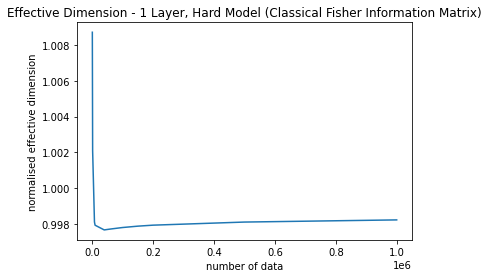

In [24]:
plt.plot(n, effdim)
plt.ylabel("normalised effective dimension")
plt.xlabel("number of data")
plt.title("Effective Dimension - 1 Layer, Hard Model (Classical Fisher Information Matrix)")

In [25]:
np.save("Data/2qubits_1layerhard_f_hats_pauli.npy", f)
np.save("Data/2qubits_1layerhard_effective_dimension_pauli.npy", effdim)

In [26]:
eff_dimeasy = np.load("Data/2qubits_1layer_effective_dimension_pauli.npy", allow_pickle=True)

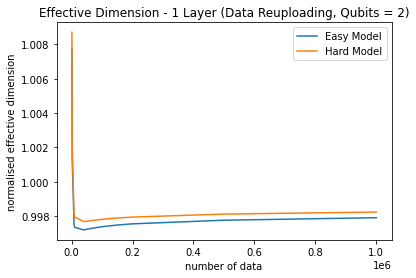

In [27]:
plt.plot(n, eff_dimeasy)
plt.plot(n, effdim)

plt.xlabel("number of data")
plt.ylabel("normalised effective dimension")
plt.title("Effective Dimension - 1 Layer (Data Reuploading, Qubits = 2)")

legendList = ['{}'.format(i) for i in ["Easy Model", "Hard Model"]]
plt.legend(legendList)